In [1]:
import sys
sys.path.insert(0, "src/")
import matplotlib
import pandas as pd
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import numpy as np
from skimage import io
from skimage.color import rgb2gray, rgba2rgb
from colors import color
import sklearn as sl
import skimage
from sklearn.metrics import mean_squared_error as MSE
from data import Sample, smooth, Spectra
from scipy.optimize import basinhopping
from camera import CameraCalibration
from tmm.tmm_core import coh_tmm, unpolarized_RT
import copy
import os
from scipy.integrate import trapz
from data import SpectraTheory, SyntheticSpectra, SampleArray, AttributeDict
from camera import CameraCalibration
from collections import defaultdict
from skimage.color import label2rgb
import dill as pickle
from skimage import measure
from scipy.ndimage import gaussian_filter
%load_ext autoreload
%autoreload 2

In /home/makam0a/anaconda3/envs/prima/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /home/makam0a/anaconda3/envs/prima/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.level rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /home/makam0a/anaconda3/envs/prima/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.


In [2]:
DATA = 'data/'
METADATA = 'metadata/'

In [3]:
camera = CameraCalibration.load(METADATA + 'camera_lu_final.npy')
samples_file=METADATA + 'ab_samples_lu_final.npy'
samples = np.load(samples_file,allow_pickle=True)

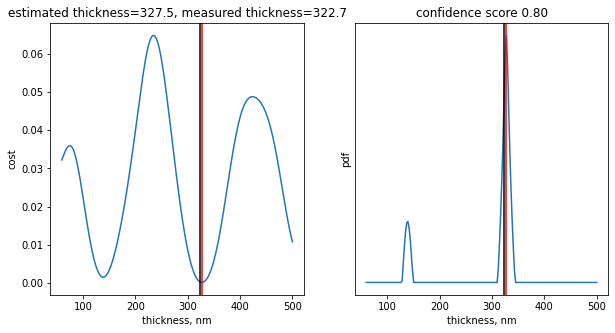

In [4]:
from optimization import confidence, myfun_color, wavels, get_refl
dmin=60
dmax=500
sample=np.random.choice(samples)
ds = np.linspace(dmin,dmax,200)
cost_functions=[myfun_color(d,sample, camera) for d in ds]
d0=ds[np.argmin(cost_functions)]

def plot(cost_functions, ds, d0, file=None):
    plt.figure(figsize=[10,5])
    plt.subplot(121)
    plt.title('estimated thickness=%.1f, measured thickness=%.1f' % (d0,sample.thickness))
    plt.plot(ds,cost_functions)
    plt.axvline(d0,color='r', label='estimated thickness')
    plt.axvline(sample.thickness, color='k', label='measured thickness')
    plt.xlabel('thickness, nm')
    plt.ylabel('cost')
    #
    plt.subplot(122)
    pdf, conf = confidence(cost_functions, ds)
    plt.title('confidence score %.2f' % conf)
    plt.plot(ds,pdf)
    plt.yticks([])
    plt.axvline(d0,color='r', label='estimated thickness')
    plt.axvline(sample.thickness, color='k', label='measured thickness')
    plt.xlabel('thickness, nm')
    plt.ylabel('pdf')
    if file is None:
        plt.show()
    else:
        plt.savefig(METADATA + 'results/color-thickness/' + file + '.png')
plot(cost_functions, ds, d0)

In [5]:
estimated_thicknesses = []
gt_thicknesses = []
confidences = []

for sample in samples:
    ds = np.linspace(dmin, dmax, 200)
    cost_functions = [myfun_color(d, sample, camera) for d in ds]
    d0 = ds[np.argmin(cost_functions)]
    print('estimated thickness', d0)
    print('measured thickness', sample.thickness)
    plt.figure(figsize=[10, 5])
    plt.subplot(121)
    plt.title('estimated thickness=%.1f, measured thickness=%.1f' % (d0, sample.thickness))
    plt.plot(ds, cost_functions)
    plt.axvline(d0, color='r', label='estimated thickness')
    plt.axvline(sample.thickness, color='k', label='measured thickness')
    plt.xlabel('thickness, nm')
    plt.ylabel('cost')
    plt.subplot(122)
    pdf, conf = confidence(cost_functions, ds)
    plt.title('confidence score %.2f' % conf)
    plt.plot(ds, pdf)
    plt.yticks([])
    plt.axvline(d0, color='r', label='estimated thickness')
    plt.axvline(sample.thickness, color='k', label='measured thickness')
    estimated_thicknesses.append(d0)
    gt_thicknesses.append(sample.thickness)
    confidences.append(conf)
    plt.xlabel('thickness, nm')
    plt.ylabel('pdf')
    plt.savefig(METADATA + 'results/color-thickness/' + sample.filename + '2.png')
    plt.close()

estimated thickness 90.9547738693
measured thickness 86.6
estimated thickness 82.1105527638
measured thickness 78.6
estimated thickness 82.1105527638
measured thickness 84.3
estimated thickness 66.6331658291
measured thickness 66.6
estimated thickness 64.4221105528
measured thickness 63.3
estimated thickness 327.537688442
measured thickness 322.7
estimated thickness 292.16080402
measured thickness 283.0
estimated thickness 254.572864322
measured thickness 252.7
estimated thickness 234.673366834
measured thickness 233.0
estimated thickness 210.351758794
measured thickness 209.9
estimated thickness 289.949748744
measured thickness 283.5
estimated thickness 314.271356784
measured thickness 310.0
estimated thickness 334.170854271
measured thickness 329.2
estimated thickness 371.75879397
measured thickness 366.7
estimated thickness 429.246231156
measured thickness 420.3
estimated thickness 119.698492462
measured thickness 119.0
estimated thickness 106.432160804
measured thickness 105.2
esti

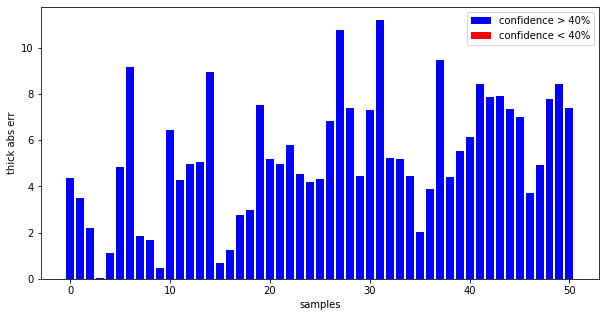

In [6]:
estimated_thicknesses = np.array(estimated_thicknesses)
gt_thicknesses = np.array(gt_thicknesses)
confidences = np.array(confidences)
plt.figure(figsize=[10,5])
difference = np.abs(estimated_thicknesses-gt_thicknesses)
plt.bar(np.arange(len(samples)),difference,color='b', label = 'confidence > 40%')
mask = confidences > 0.4
difference[mask] = 0
plt.bar(np.arange(len(samples)), difference, color='r',label = 'confidence < 40%')
plt.legend()
plt.xlabel('samples')
plt.ylabel('thick abs err')
plt.show()

In [7]:
cost_function=MSE
mats_dir='mats/'
data_Si=np.loadtxt(mats_dir+'Si.txt')
data_PMMA=np.loadtxt(mats_dir+'PMMA_nam_dispersion.txt')
wl, n, k = data_Si[:,0], data_Si[:,1], data_Si[:,2]
Si_n= interp1d(wl, n)
Si_k= interp1d(wl, k)
wl, n = data_PMMA[:,0], data_PMMA[:,1]
PMMA_n= interp1d(wl, n)
wavels = np.linspace(405, 740, 70)

def myfun_n_color(d, n, RGB, camera:CameraCalibration):
    _, spectra = refl.get_refl(d,n)
    #spectra = np.zeros_like(wavels)
    y_pred = camera.spectra_to_XYZ(wavels,spectra)
    y_true = RGB
    return cost_function(y_true, y_pred)

def myfun_same_n_color(n, samples, camera:CameraCalibration, dmin=50,dmax=700, dn=300):
    ds = np.linspace(dmin,dmax,dn)
    cost_functions = np.zeros((len(samples),len(ds)))
    thicknesses = np.zeros(len(samples))
    for i, sample in enumerate(samples):
        tmp = [myfun_n_color(d,n,sample.image.color,camera) for d in ds]
        cost_functions[i]=tmp
        thicknesses[i]=ds[np.argmin(tmp)]
    return cost_functions, thicknesses

class FReflection():
    def __init__(self, reflection_arr, ds, nlist, wavels):
        self.reflection = reflection_arr
        self.ds = ds
        self.nlist = nlist
        self.wavels = wavels
        
    def get_refl(self, d, n):
        idx_n = np.argmin(np.abs(self.nlist-n))
        idx_d = np.argmin(np.abs(self.ds-d))
        return (self.wavels, self.reflection[idx_d,idx_n])
    
    @classmethod
    def compute(cls,ds,nlist,wavels):
        reflection = np.zeros([len(ds),len(nlist),len(wavels)])
        for i, d in enumerate(ds):
            for j, n in enumerate(nlist):
                reflection[i,j,:] = [get_refl(wl, d, lambda x: n) for wl in wavels]
        return cls(reflection, ds, nlist, wavels)
    
    @classmethod
    def load(cls,fname='precomputed_reflection.npy'):
        with open(fname,'rb') as file:
            cls_object = pickle.load(file)
        return cls_object
    
    def save(self,fname='precomputed_reflection.npy'):
        with open(fname,'wb') as file:
            pickle.dump(self,file)

ds = np.linspace(50,500,200)
nlist = np.linspace(1.2,2.4,100)
gt_thicknesses = np.array([sample.thickness for sample in samples])
#refl = FReflection.compute(ds,nlist,wavels)

In [8]:
# refl = FReflection.compute(ds,nlist,wavels)
# refl.save(METADATA + 'n_on_silicon_precomputed_refr.npy')
refl = FReflection.load(METADATA + 'n_on_silicon_precomputed_refr.npy')

In [9]:
%%time
import multiprocessing as mp
def processn(i):
    print("I'm process", os.getpid())
    
def cost_n(i,n):
    processn(i)
    return myfun_same_n_color(n, samples,camera)

ds = np.linspace(50,700,300)
nlist = np.linspace(1.1,2.5,96)
cost_functions = np.zeros([len(nlist), len(samples), len(ds)])
thicknesses = np.zeros([len(nlist), len(samples)])

pool = mp.Pool(mp.cpu_count())
result_objects = [pool.apply_async(cost_n, args=[j,n])for j, n in enumerate(nlist)]
results = [r.get() for r in result_objects]
pool.close()
pool.join()

for i, (cf, tk) in enumerate(results):
    cost_functions[i] = cf
    thicknesses[i] = tk

I'm process 22341
I'm process 22344
I'm process 22351
I'm process 22345
I'm process 22349
I'm process 22350
I'm process 22347
I'm process 22346
I'm process 22353
I'm process 22343
I'm process 22342
I'm process 22352
I'm process 22348
I'm process 22354
I'm process 22355
I'm process 22356
I'm process 22357
I'm process 22359
I'm process 22361
I'm process 22360
I'm process 22363
I'm process 22364
I'm process 22358
I'm process 22362
I'm process 22364
I'm process 22361
I'm process 22363
I'm process 22362
I'm process 22356
I'm process 22357
I'm process 22359
I'm process 22358
I'm process 22360
I'm process 22347
I'm process 22355
I'm process 22350
I'm process 22351
I'm process 22354
I'm process 22353
I'm process 22349
I'm process 22352
I'm process 22348
I'm process 22345
I'm process 22346
I'm process 22344
I'm process 22343
I'm process 22342
I'm process 22341
I'm process 22364
I'm process 22361
I'm process 22362
I'm process 22363
I'm process 22357
I'm process 22360
I'm process 22359
I'm proces

0.742062046726


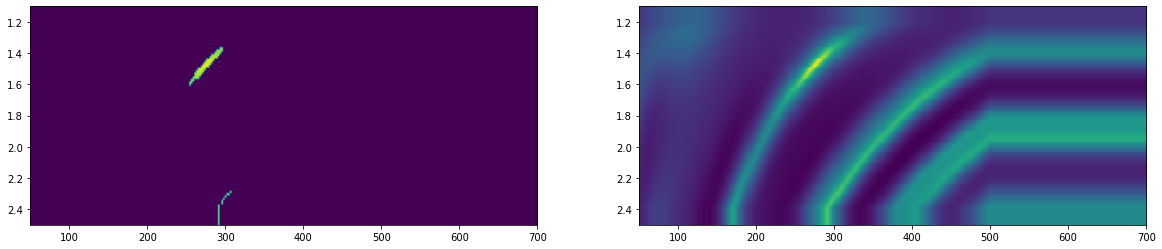

In [10]:
def get__mask(values, argument, sigma):
    return (values>=(values[argument]-sigma)) & (values<=(values[argument]+sigma))

def confidence2d(cost, ds, nlist, sigma_n = 0.1, sigma_d = 25, th=0.8):
    tmp = cost.copy()
    conf = -np.log(tmp)
    mask = conf < conf.max() * th
    conf[mask] = 0
    conf_min = np.unravel_index(conf.argmax(),conf.shape)
    n_indices = get__mask(nlist,conf_min[0],sigma=sigma_n)
    ds_indices = get__mask(ds,conf_min[1],sigma=sigma_d)
    C = conf.sum()
    C1 = conf[n_indices,:][:,ds_indices].sum()
    return C1/C, conf

cluster = 1
idx = np.random.randint(50)
tmp = cost_functions[:,:,:][:,idx,:]
confidence, _ = confidence2d(cost_functions[:,:,:][:,idx,:], ds, nlist)
print(confidence)
tmp = -np.log(tmp)
th = 0.8
mask = tmp < tmp.max() * th
tmp[mask] = 0
plt.figure(figsize=[20,10])
plt.subplot(121)
plt.imshow(tmp,aspect=200,extent=[min(ds),max(ds),max(nlist),min(nlist)])
plt.subplot(122)
plt.imshow(-np.log(cost_functions[:,:,:][:,idx,:]),aspect=200,extent=[min(ds),max(ds),max(nlist),min(nlist)])
plt.show()

In [11]:
nx, sx, dx = cost_functions.shape
confidences = np.array([confidence2d(cost_functions[:,i,:],ds,nlist)[0] for i in range(sx)])
pdfs = np.array([confidence2d(cost_functions[:,i,:],ds,nlist)[1] for i in range(sx)])

  File "/home/makam0a/anaconda3/envs/prima/lib/python3.7/site-packages/matplotlib/axes/_axes.py", line 2782, in stem
    'In Matplotlib 3.3 individual lines on a stem plot will be '
  File "/home/makam0a/anaconda3/envs/prima/lib/python3.7/site-packages/matplotlib/cbook/__init__.py", line 1993, in _warn_external
    warnings.warn(message, category, stacklevel)
/home/makam0a/anaconda3/envs/prima/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


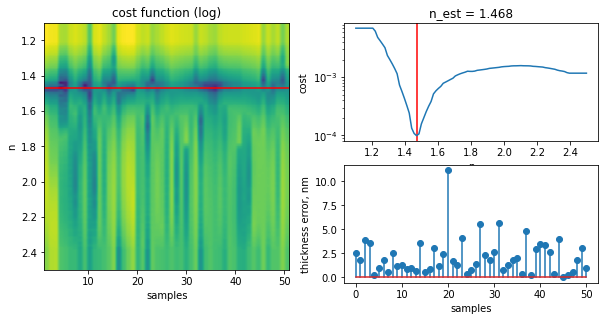

In [13]:
def plot_cost(cost, confidence_th=0, nlist = nlist, ds = ds, confidences=confidences):
    mask = (confidences > confidence_th)
    cluster_samples = samples[mask]
    tmp = cost[:,mask].mean(axis=1)
    ibest = cost[:,mask].mean(axis=1).argmin()
    nest = nlist[cost[:,mask].mean(axis=1).argmin()]
    plt.figure(figsize=[10,10])
    plt.subplot(221)
    plt.title('cost function (log)')
    plt.imshow(np.log(cost[:,mask]),aspect=len(cluster_samples)//(max(nlist)-min(nlist)),extent=[1,len(cluster_samples),nlist.max(),nlist.min()])
    plt.axhline(nest,color='r')
    plt.xlabel('samples')
    plt.ylabel('n')
    plt.subplot(422)
    plt.title('n_est = %.3f' % (nest))
    plt.axvline(nest,color='r', label='estimated refractive')
    plt.plot(nlist,tmp)
    plt.xlabel("n")
    plt.ylabel('cost')
    plt.yscale('log')
    plt.subplot(424)
    #plt.plot(np.abs(gt_thicknesses-thicknesses[ibest]), )
    plt.stem(np.abs(gt_thicknesses-thicknesses[ibest]))
    plt.xlabel("samples")
    plt.ylabel("thickness error, nm")
    plt.show()
    return ibest, nest

pooled_cost_functions = cost_functions.min(axis=-1)
ibest, nest = plot_cost(pooled_cost_functions,confidence_th=0.0)